Importando bibliotecas

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np

Carregando o dataframe

In [2]:
df_real = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
print(df_real['stroke'].value_counts())


stroke
0    4861
1     249
Name: count, dtype: int64


Equilibrando a base de dados, para que o número de amostras com AVC seja o mesmo que o número de amostras sem AVC

In [3]:
df = df_real.loc[:497]
print(df['stroke'].value_counts())

df = df.dropna()
df.replace(0, -1, inplace=True)
df.head()

stroke
1    249
0    249
Name: count, dtype: int64


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,-1,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,-1,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,-1,-1,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,-1,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,-1,-1,Yes,Private,Urban,186.21,29.0,formerly smoked,1


Convertendo os dados categóricos em numéricos

In [4]:
# bmi
# https://www.cdc.gov/obesity/basics/adult-defining.html#:~:text=If%20your%20BMI%20is%20less,falls%20within%20the%20obesity%20range.
bmi = df['bmi']

df['underweight'] = bmi< 18.5
df['healthy_weight'] = (18.5 <= bmi) & (bmi < 25)
df['overweight'] = (25 <= bmi) & (bmi < 30)
df['obesity'] = 30 <= bmi


# avg_glucose_level
# https://www.cdc.gov/diabetes/basics/getting-tested.html#:~:text=A%20fasting%20blood%20sugar%20level,higher%20indicates%20you%20have%20diabetes.
glucose = df['avg_glucose_level']
df['normal_glucose_level'] = glucose <= 99
df['prediabetes'] = (100 <= glucose) & (glucose <=125)
df['diabetes'] = 126 <= glucose

# age 
age = df['age']
df['children'] = age <= 12
df['teen'] = (13<=age ) & (age<=19)
df['adult'] = (20 <=age) & (age<=39)
df['middle_age'] = (40<=age) & (age<=59)
df['senior'] = 60 <= age 

df = pd.get_dummies(df, dtype=float)
df.replace(False, -1, inplace=True)
df.replace(True, 1, inplace=True)
df.replace(0, -1, inplace=True)
df.head(2)


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,underweight,healthy_weight,overweight,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,-1,1,228.69,36.6,1,-1,-1,-1,...,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0
2,31112,80.0,-1,1,105.92,32.5,1,-1,-1,-1,...,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0


Separando as características dos resultados (se a pessoa teve ou não um AVC)

In [5]:
# caracteríticas
X = df.drop(['id', 'stroke', 'age', 'avg_glucose_level', 'bmi'], axis=1)
X = X.astype('float64')

# resultados
y = df['stroke']
y = y.astype('float64')

Separando linhas de dados em treino e teste

In [6]:
def separador_treino_teste(X, y):
    '''
    Separa os dados em dados de treino e dados de teste de acordo com
    X -> características
    y -> resultados
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
    X_train,  X_test = X_train.to_numpy().T,  X_test.to_numpy().T
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    return X_train, X_test, y_train, y_test

funções auxiliares utilizadas para analisar os resultados dos classificadores

In [9]:
# lista com os nomes das caracterísitcas
caracteristicas = list(X.columns)

# {nome da caracteríticas: índice da característica na lista acima}
indices = {f: caracteristicas.index(f) for f in caracteristicas}

def accuracy(y_test, y_est):
    '''Calcula a acurácia do classificador baseado 
    no resultado estimado e o resultado de teste'''

    return np.mean(np.sign(y_test)==np.sign(y_est))


def acuracia_hipotese_nula(y_test):
    '''Calcula a acurácia considerando a hipótese nula 
    (classificador que sempre resulta na maioria)'''

    sem_avc = np.count_nonzero(y_test == -1)
    com_avc = np.count_nonzero(y_test == 1)
    maior = max(sem_avc, com_avc)
    return maior / len(y_test)


def tabela_relevancia(w_):
    '''Ranking das features dependendo da ordem de importância'''
    df_ = pd.DataFrame()
    df_['features'] = X.columns
    df_['pontuação'] = w_
    df_.sort_values(by='pontuação', inplace=True, ascending=False)
    df_ = df_.reset_index()
    return df_[['features', 'pontuação']]


def pontua_features_positivas(pesos, w):
    '''Fornece pontos para os 10 primeiros colocados no ranking, 
    sendo o número de pontos equivalente a colocação da feature'''
    w = [x for _, x in sorted(zip(w,caracteristicas))][::-1]
    for i in range(10):
        c = w[i]
        indice = indices[c]
        pesos[indice] += 10 - i


def pontua_features_negativas(pesos, w):
    '''Fornece pontos negativos para os 10 últimos colocados no ranking, 
    sendo o número de pontos equivalente a colocação da feature no ranking 
    dos piores colocados'''
    w = [x for _, x in sorted(zip(w,caracteristicas))]
    for i in range(10):
        c = w[i]
        indice = indices[c]
        pesos[indice] -= 10 - i


## Classificação linear

A metodologia usada para a **classificação linear** utiliza a técnica de gradiente descendente para minimizar a função de perda, definida como a média dos erros quadráticos entre as saídas previstas e as saídas reais.

**(1)** A função de perda é definida na função `loss()`, que recebe como entrada um vetor de parâmetros contendo o vetor de pesos `w`, o viés `b`, os dados de entrada `pontos` e os alvos `val`. A função calcula a saída estimada `est` usando os pesos e o viés, calcula o erro quadrático médio `mse`, comparando a saída estimada com os alvos. Por fim, retorna o valor do erro.

**(2)** A função de gradiente `g` é definida usando a biblioteca autograd, que permite calcular automaticamente o gradiente da função de perda em relação aos parâmetros `w` e `b`.

**(3)** Em seguida, os dados de treinamento são definidos como pontos e alvos, respectivamente, e os pesos `w` são inicializados aleatoriamente. O tamanho do passo alpha é definido como $10^-3$.

**(4)** Em um loop, o gradiente da função de perda é calculado usando a função g e os pesos `w` e o viés `b` são atualizados com o tamanho do passo multiplicado pelo gradiente. O número de iterações é definido como $10^4$.

**(5)** Após o treinamento, os pesos `w` e o viés b são usados para calcular a saída prevista `y_hat` para os dados de teste `X_test`, que é então comparada com os alvos `y_test` para calcular a acurácia do modelo. 


In [20]:
import autograd.numpy as np_ 
from autograd import grad

# (1)
def loss( parametros ):
    w, b, pontos, val = parametros # parametros como vetores
    est = w.T @ pontos + b
    mse = np_.mean( (est - val)**2)

    return mse

def classificador_linear(n_vezes):
    acuracias = []
    acuracia_nula = []
    pesos = [0 for _ in range(len(caracteristicas))]

    # (2)
    g = grad(loss)

    for i in range(n_vezes):
        
        # separa os dados em dados de treino e dados de teste
        X_train, X_test, y_train, y_test = separador_treino_teste(X, y)

        # (3)
        w = np.random.randn(X_train.shape[0],1)
        b = 0.0
        alpha = 10**-3

        # (4)
        for n in range(10**4):
            grad_ = g( (w, b, X_train, y_train) )
            w -= alpha*grad_[0]
            b -= alpha*grad_[1]

        # (5)
        y_hat = w.T @ X_test + b

        # calculo da acuracia do classificador
        acuracias.append(accuracy(y_hat, y_test))

        # calculo da acuracia de um classificador de hipótese nula
        acuracia_nula.append(acuracia_hipotese_nula(y_test))

        # pontuação das features de maior influência e de menor influência
        pontua_features_positivas(pesos, w)
        pontua_features_negativas(pesos, w)

    # calcula a média de ambas acuracias das n iterações realizadas
    acuracia = [np.mean(acuracias), np.mean(acuracia_nula)]
        
    return pesos, acuracia


### Resultados do classificador linear

Foram realizados 100 testes com o classificador linear e em cada teste foi designados pontos positivos para os 10 melhores colocados e pontos negativos para os 10 piores colocados. Esses pontos tem valor absoluto proporcional a ordem de importância das características encontrada pelo classificador.

In [32]:
pesos, acuracias = classificador_linear(100)
print(f'Acurácia: {acuracias[0]}')
print(f'Acurácia de hipótese nula: {acuracias[1]}')

Acurácia: 0.6933480176211454
Acurácia de hipótese nula: 0.5390748898678414


In [31]:
df_linear = tabela_relevancia(pesos)
df_linear.head(30)

,features,peso
0,senior,381
1,middle_age,99
2,work_type_Private,90
3,smoking_status_smokes,83
4,overweight,80
5,hypertension,65
6,ever_married_Yes,61
7,gender_Male,57
8,work_type_Self-employed,31
9,smoking_status_formerly smoked,30


## Classificador por árvore

O classificador por árvore de decisão classifica a features por ordem de relevância para descobrir se a pessoa em questão teve ou não um AVC. A árvore é montada levando em consideração a entropia de cada característica, ou seja, o quanto de informação tal característica carrega em relação a pergunta "fulano teve um AVC?".

In [37]:
def classificador_arvore(n_vezes):
    acuracias = []
    acuracia_nula = []
    pesos = [0 for _ in range(len(caracteristicas))]
    for i in range(n_vezes):
        
        # separa os dados em dados de treino e dados de teste
        X_train, X_test, y_train, y_test = separador_treino_teste(X, y)
        df_rotulo = y_train
        df_features = X_train.T
        
        # monta a árvore de decisão baseado na entropia de cada uma das
        # características dos dados de treino
        tree = DecisionTreeClassifier(criterion='entropy')
        tree.fit(df_features, df_rotulo)

        # lista com as importâncias das features
        w_arvore = tree.feature_importances_

        # teste das importancias calculadas para classificar os dados de X_test 
        y_est = w_arvore.T @ X_test 

        # calcula acurácia
        acuracias.append(accuracy(y_est, y_test))
        acuracia_nula.append(acuracia_hipotese_nula(y_test))

        # pontua classificações
        pontua_features_positivas(pesos, w_arvore)
        pontua_features_negativas(pesos, w_arvore)

    acuracia_resultado = [np.mean(acuracias), np.mean(acuracia_nula)]
    return pesos, acuracia_resultado, tree

### Resultados do classificador de árvore

In [49]:
pesos, acuracias, tree = classificador_arvore(100)
acuracia = np.mean(acuracias)
print(f'Acurácia: {acuracias[0]}')
print(f'Acurácia de hipótese nula: {acuracias[1]}')

Acurácia: 0.5718502202643171
Acurácia de hipótese nula: 0.535330396475771


In [50]:
df_arvore = tabela_relevancia(pesos)
df_arvore.head(30)

,features,peso
0,senior,997
1,middle_age,796
2,hypertension,446
3,smoking_status_never smoked,309
4,normal_glucose_level,259
5,work_type_Self-employed,214
6,Residence_type_Urban,213
7,smoking_status_smokes,183
8,Residence_type_Rural,175
9,smoking_status_formerly smoked,159


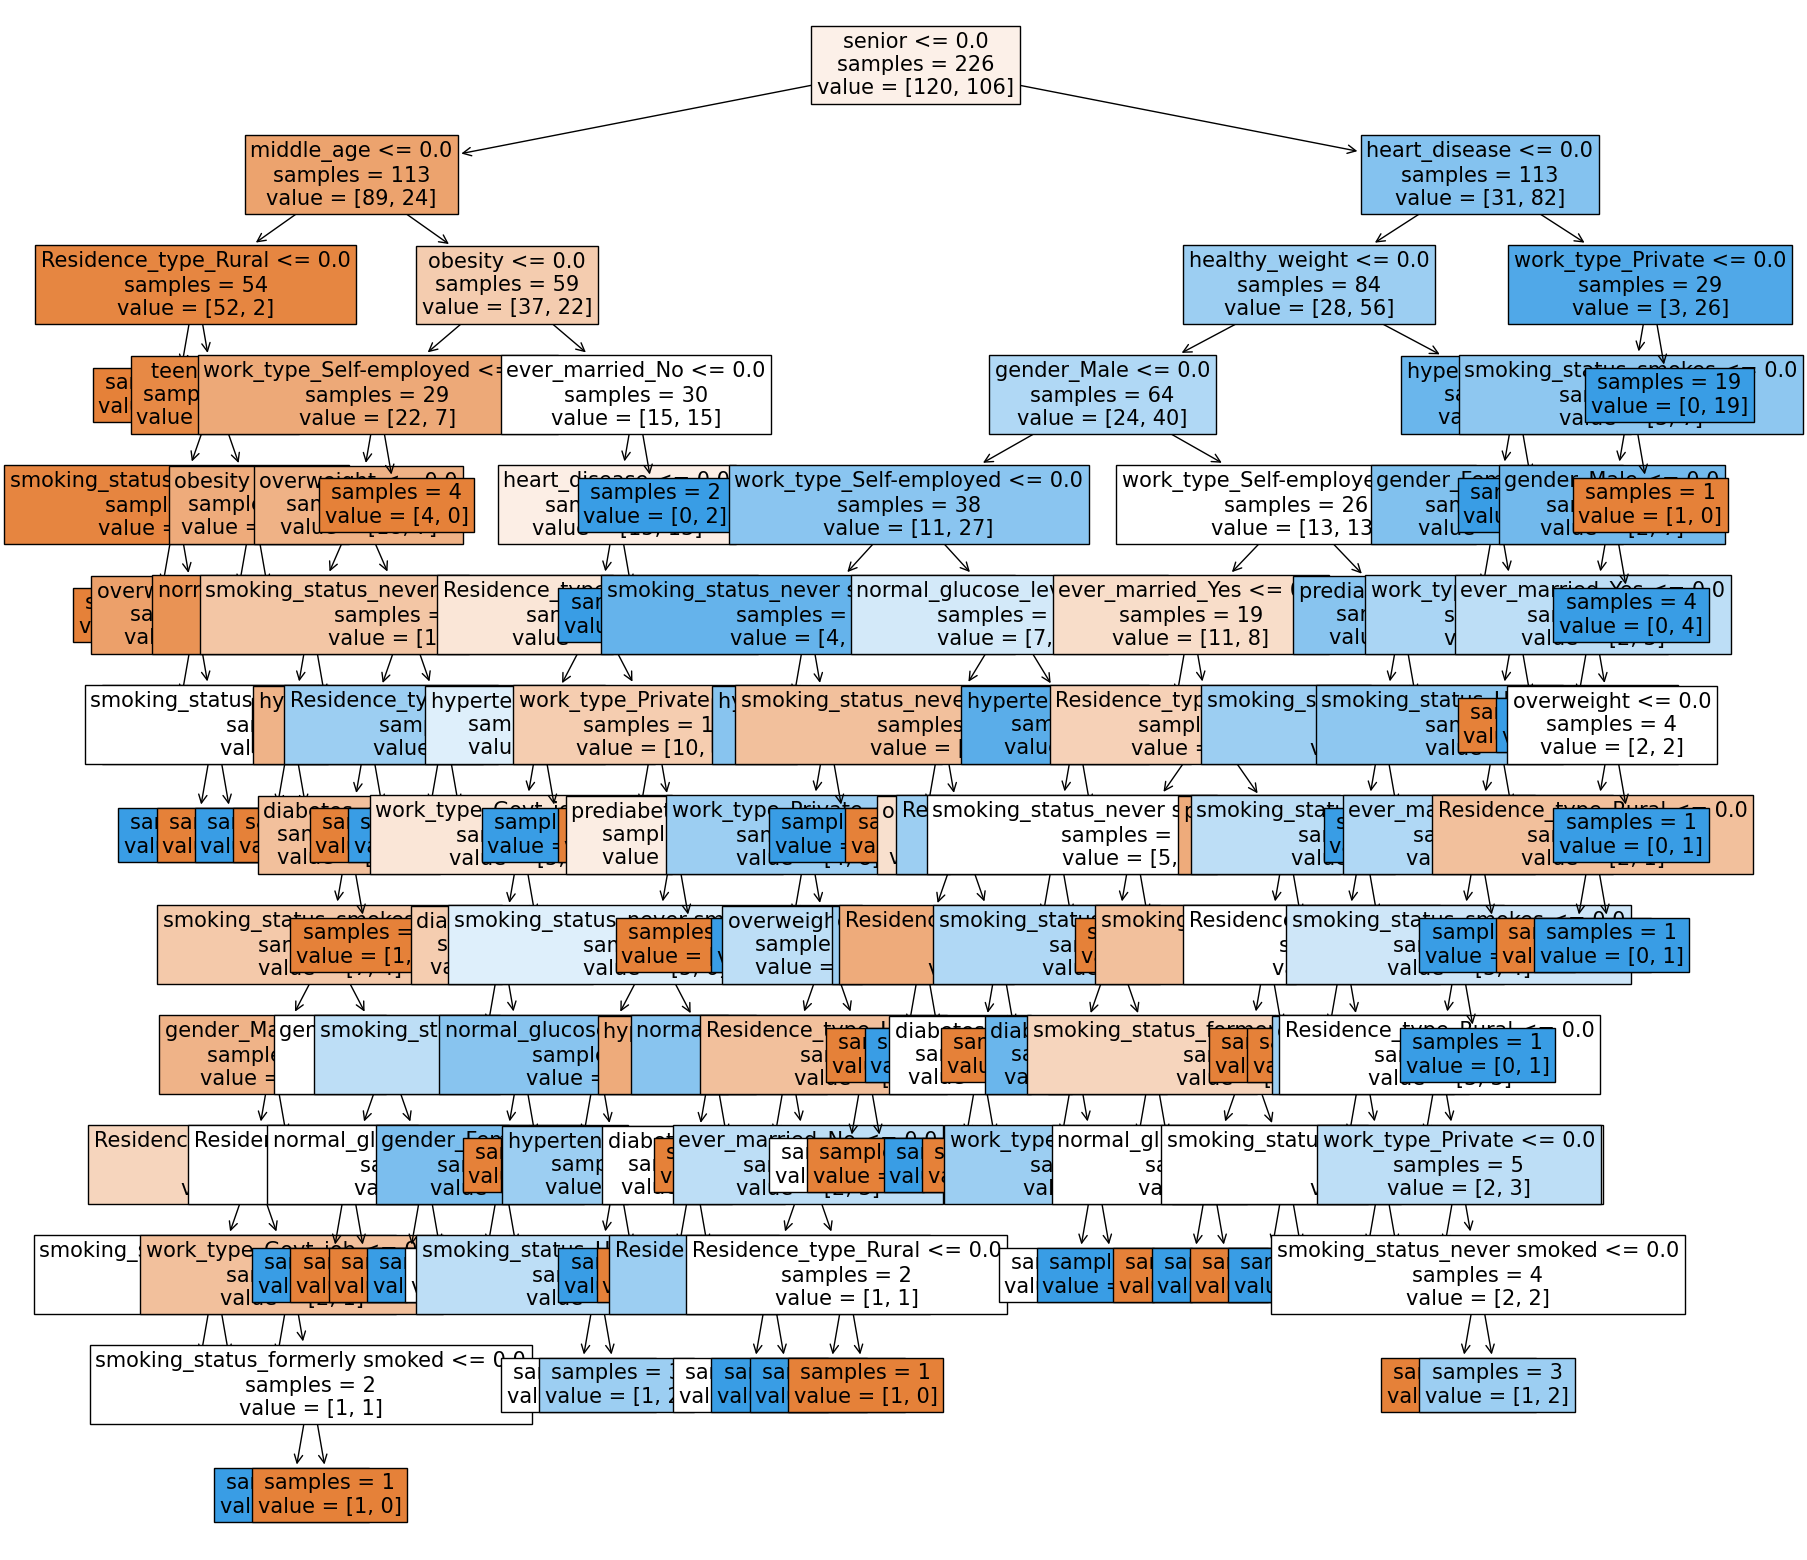

In [81]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure( figsize=(20,20) )
a = plot_tree(tree, feature_names=X.columns, fontsize=15, 
              node_ids=False, impurity=False, filled=True)
plt.savefig(fname='arvore_decisao')